# Forecasting Violent Crime by ZIP Code


This notebook trains and compares four models to forecast monthly violent crime at zip code level in Los Angeles:
1. **Linear Baseline (TensorFlow)** – Regularized linear regression on lagged crime + socioeconomic features.  
2. **XGBoost (Poisson)** – Gradient boosted trees optimized for count data.  
3. **Deep Neural Network (DNN)** – Fully connected network on the same feature set.  
4. **Hybrid LSTM** – Sequence model that combines 3‑month crime history with static features.


## Model Results:
| Model Architecture  | Validation RMSE (Selection Metric) | Test MSE (Loss) | Test RMSE (Std Dev) | Test MAE (Accuracy) |
| ------------------- | ---------------------------------- | --------------- | ------------------- | ------------------- |
| **Linear Baseline**     | 9.80                               | 110.66          | 10.52               | 7.31                |
| **XGBoost (Poisson)**   | 9.26                               | **103**             | **10.15**               | **6.59**                |
| **Deep Neural Network** | 9.14                               | 106.26          | 10.31               | 6.75                |
| **Hybrid LSTM**         | **9.09**                               | 105.56          | 10.27               | 6.76                |



In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import pickle

import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

import tensorflow as tf
from tensorflow.keras import layers, models, metrics, callbacks, Input, Model

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

import os

os.chdir("/home/tildahh/Documents/207_lab")
print(os.getcwd())

True NVIDIA GB10
TensorFlow: 2.20.0
GPUs: []
/home/tildahh/Documents/207_lab


In [25]:
# load dataset 
# train = pd.read_csv('data/train.csv')
# test = pd.read_csv('data/test.csv')
# val = pd.read_csv('data/validation.csv')
df = pd.read_csv('/home/tildahh/Documents/207_lab/data/data_stack.csv')

print("df shape:", df.shape)
df.head()

df shape: (6705, 16)


,Unnamed: 0,ZCTA,incident_month_timestamp,crime_Non-Violent,crime_Violent,violent_lag_1,violent_lag_2,violent_lag_3,season,month_sin,month_cos,pop_total,median_household_income,gini_index,unemployment_rate,poverty_rate
0,0,90001,2020-04-01,16.0,25.0,16.0,12.0,38.0,spring,8.660254e-01,-0.500000,56403,60751.0,0.416,0.096901,0.205254
1,1,90001,2020-05-01,31.0,22.0,25.0,16.0,12.0,spring,5.000000e-01,-0.866025,56403,60751.0,0.416,0.096901,0.205254
2,2,90001,2020-06-01,29.0,36.0,22.0,25.0,16.0,summer,1.224647e-16,-1.000000,56403,60751.0,0.416,0.096901,0.205254
3,3,90001,2020-07-01,37.0,27.0,36.0,22.0,25.0,summer,-5.000000e-01,-0.866025,56403,60751.0,0.416,0.096901,0.205254
4,4,90001,2020-08-01,24.0,29.0,27.0,36.0,22.0,summer,-8.660254e-01,-0.500000,56403,60751.0,0.416,0.096901,0.205254


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6705 entries, 0 to 6704
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                6705 non-null   int64  
 1   ZCTA                      6705 non-null   int64  
 2   incident_month_timestamp  6705 non-null   object 
 3   crime_Non-Violent         6705 non-null   float64
 4   crime_Violent             6705 non-null   float64
 5   violent_lag_1             6705 non-null   float64
 6   violent_lag_2             6705 non-null   float64
 7   violent_lag_3             6705 non-null   float64
 8   season                    6705 non-null   object 
 9   month_sin                 6705 non-null   float64
 10  month_cos                 6705 non-null   float64
 11  pop_total                 6705 non-null   int64  
 12  median_household_income   6300 non-null   float64
 13  gini_index                6345 non-null   float64
 14  unemploy

## Standardize and Cleaning

In [27]:
# Standardize column names to lowercase
df.columns = [col.lower() for col in df.columns]

# Ensure the date column is in datetime format for sorting/splitting
df['incident_month_timestamp'] = pd.to_datetime(df['incident_month_timestamp'])

# Sort data by Zip Code and Date to ensure lags/rolling windows are calculated correctly
df = df.sort_values(by=['zcta', 'incident_month_timestamp']).reset_index(drop=True)

## Feature Engineering

We construct lagged crime features, a 3‑month rolling average, and interaction terms (`economic_stress` and `crime_density`) to capture temporal dynamics and socioeconomic context.

In [28]:
# Ensure we do not accidentally use future information
# all lags and rolling statistics are constructed using past months only.
df['non_violent_lag_1'] = df.groupby('zcta')['crime_non-violent'].shift(1)

# 3 Month Rolling Average of Violent Crime to capture trends
# This smooths out month-to-month noise. Apply this to 'violent_lag_1' so that it represents the average of t-1, t-2, and t-3.
df['violent_3mo_avg'] = df.groupby('zcta')['violent_lag_1'].transform(lambda x: x.rolling(window=3).mean())

# Interaction Features (Optional but recommended for Trees) - Economic Stress
df['economic_stress'] = df['unemployment_rate'] * df['poverty_rate']

# Crime Density - violent crime history relative to population size
df['crime_density_lag'] = df['violent_lag_1'] / (df['pop_total'] + 1) # (Adding 1 to population to avoid division by zero if any errors exist)

In [29]:
df.columns

Index(['unnamed: 0', 'zcta', 'incident_month_timestamp', 'crime_non-violent',
       'crime_violent', 'violent_lag_1', 'violent_lag_2', 'violent_lag_3',
       'season', 'month_sin', 'month_cos', 'pop_total',
       'median_household_income', 'gini_index', 'unemployment_rate',
       'poverty_rate', 'non_violent_lag_1', 'violent_3mo_avg',
       'economic_stress', 'crime_density_lag'],
      dtype='object')

In [30]:
engineered_cols = [
    "violent_lag_1",
    "violent_lag_2",
    "violent_lag_3",
    "month_sin",
    "month_cos",
    "season",
    "pop_total",
    "median_household_income",
    "gini_index",
    "unemployment_rate",
    "poverty_rate",
    "non_violent_lag_1",
    "violent_3mo_avg",
    "economic_stress",
    "crime_density_lag"
]
target = "crime_violent"

In [31]:
# missing values check 
df[engineered_cols + [target]].isnull().sum().sort_values(ascending=False)

median_household_income    405
gini_index                 360
violent_3mo_avg            298
unemployment_rate          180
poverty_rate               180
economic_stress            180
non_violent_lag_1          149
violent_lag_1                0
violent_lag_2                0
violent_lag_3                0
month_sin                    0
month_cos                    0
season                       0
pop_total                    0
crime_density_lag            0
crime_violent                0
dtype: int64

In [32]:
# --- Distribution / outlier checks ----------------------------------------
desc = df[engineered_cols].describe(percentiles=[0.20, 0.95]).T
print("Summary stats for engineered columns:") 
desc

Summary stats for engineered columns:


,count,mean,std,min,20%,50%,95%,max
violent_lag_1,6705.0,42.302908,48.085640,0.000,1.000000,2.800000e+01,130.000000,296.00000
violent_lag_2,6705.0,42.279940,48.099560,0.000,1.000000,2.700000e+01,130.000000,296.00000
violent_lag_3,6705.0,42.187174,48.016763,0.000,1.000000,2.700000e+01,129.000000,296.00000
month_sin,6705.0,-0.052578,0.697278,-1.000,-0.866025,-2.449294e-16,1.000000,1.00000
month_cos,6705.0,-0.030356,0.714329,-1.000,-0.866025,-1.836970e-16,1.000000,1.00000
pop_total,6705.0,34438.181208,20623.952365,0.000,18114.000000,3.184300e+04,67895.000000,102784.00000
median_household_income,6300.0,93824.435714,36771.322929,32250.000,62059.600000,8.739650e+04,170143.250000,220464.00000
gini_index,6345.0,0.483411,0.058650,0.194,0.441800,4.742000e-01,0.571200,0.74970
unemployment_rate,6525.0,0.080519,0.044736,0.000,0.058639,7.467205e-02,0.139873,0.49711
poverty_rate,6525.0,0.164822,0.144956,0.000,0.083993,1.271917e-01,0.353840,1.00000


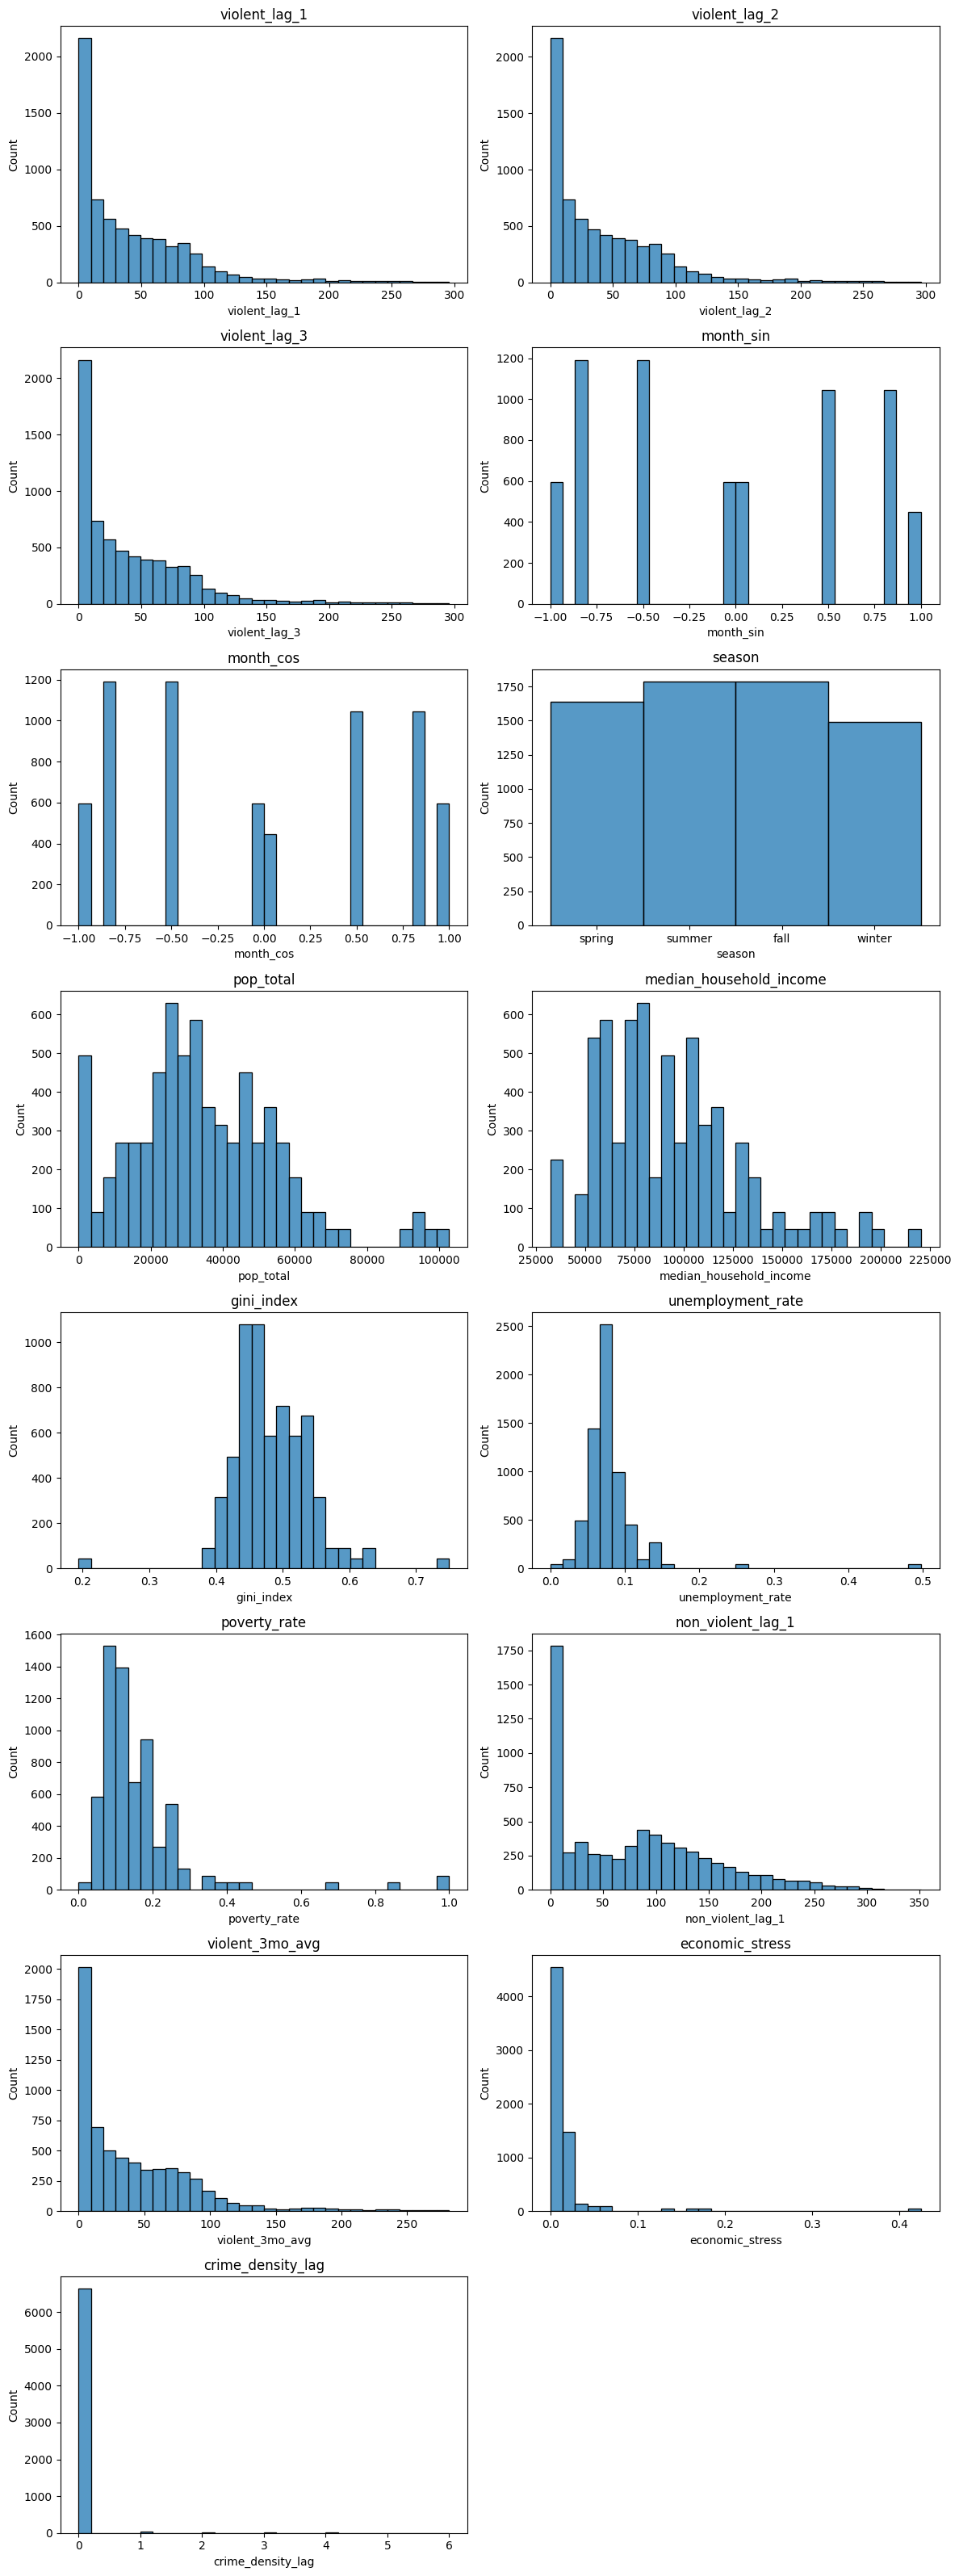

In [33]:
n_cols = len(engineered_cols)
n_rows = int(np.ceil(n_cols / 2))
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, engineered_cols):
    sns.histplot(df[col].dropna(), ax=ax, bins=30)
    ax.set_title(col)
for ax in axes[len(engineered_cols):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [34]:
# --- Correlations ----------------------------------------------------------
numeric_cols = df[engineered_cols + [target]].select_dtypes(include="number").columns
corr = df[numeric_cols].corr()[target].sort_values(ascending=False)
print("Correlation with target:\n", corr)    

Correlation with target:
 crime_violent              1.000000
violent_3mo_avg            0.976880
violent_lag_1              0.971746
violent_lag_2              0.966319
violent_lag_3              0.961471
non_violent_lag_1          0.840878
pop_total                  0.567017
poverty_rate               0.211099
unemployment_rate          0.115844
gini_index                 0.093198
economic_stress            0.026880
month_cos                 -0.033838
month_sin                 -0.038986
crime_density_lag         -0.069668
median_household_income   -0.522961
Name: crime_violent, dtype: float64


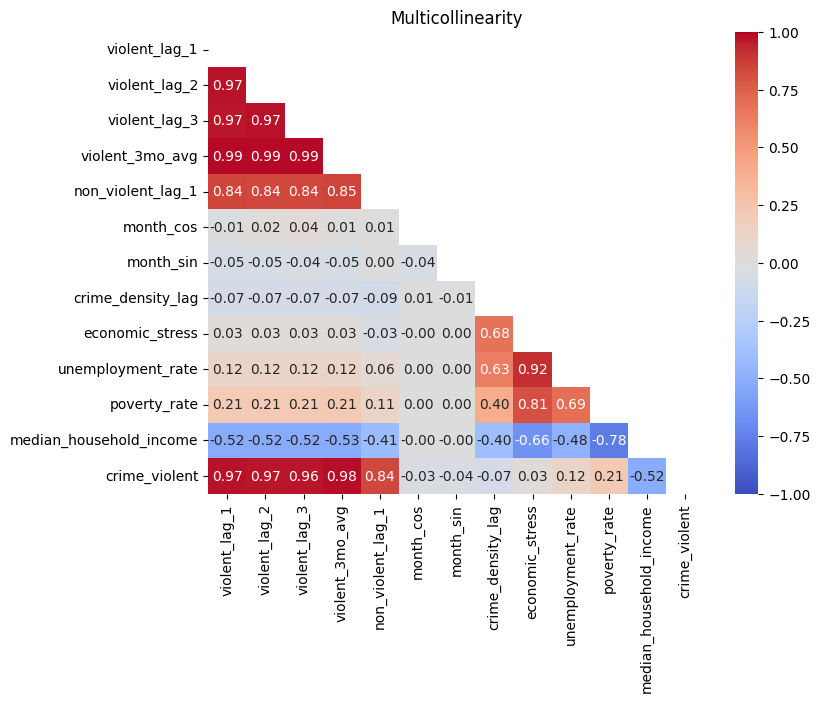

In [35]:
cols_to_check = ['violent_lag_1', 'violent_lag_2', 'violent_lag_3', 'violent_3mo_avg', 'non_violent_lag_1', 'month_cos', 'month_sin', 'crime_density_lag', 'economic_stress', 'unemployment_rate', 'poverty_rate', 'median_household_income', 'crime_violent']
corr_matrix = df[cols_to_check].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,           # hides the upper half
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1, vmax=1 
)
plt.title("Multicollinearity")
plt.show()

In [36]:
# Features for BASELINE (Linear Regression)
linear_features = [
    'violent_lag_1', 'violent_lag_2', 'violent_lag_3', 
    'non_violent_lag_1',
    'poverty_rate', 'unemployment_rate', 'median_household_income',
    'gini_index',
    'month_sin', 'month_cos',
    'crime_density_lag'
]

# Features for IMPROVEMENTS (XGBoost / DNN)
# Add the rolling average back in for the complex models
complex_features = linear_features + ['violent_3mo_avg']

In [37]:
# Columns to DROP entirely (IDs, Leakage, Targets)
drop_cols_global = [
    'zcta',                  # Identifier
    'incident_month_timestamp', # Date Object
    'crime_violent',         # Target
    'crime_non-violent',     # Leakage
    'season',                # Redundant
    'economic_stress',       # Redundant (High Multicollinearity)
    'unnamed: 0'             # Artifact
]

# Drop global junk & rows with NaNs from lags
#df_model = df.dropna().reset_index(drop=True)
df_model = df.copy()
df_model.head(2)

,unnamed: 0,zcta,incident_month_timestamp,crime_non-violent,crime_violent,violent_lag_1,violent_lag_2,violent_lag_3,season,month_sin,month_cos,pop_total,median_household_income,gini_index,unemployment_rate,poverty_rate,non_violent_lag_1,violent_3mo_avg,economic_stress,crime_density_lag
0,0,90001,2020-04-01,16.0,25.0,16.0,12.0,38.0,spring,0.866025,-0.500000,56403,60751.0,0.416,0.096901,0.205254,NaN,NaN,0.019889,0.000284
1,1,90001,2020-05-01,31.0,22.0,25.0,16.0,12.0,spring,0.500000,-0.866025,56403,60751.0,0.416,0.096901,0.205254,16.0,NaN,0.019889,0.000443


## Train / Validation / Test Split

We use a **time‑based split** rather than random shuffling:

- Train: up to 2022‑06‑01  
- Validation: 2022‑07‑01 to 2023‑03‑01  
- Test: 2023‑04‑01 to 2023‑12‑01  

This mimics a true forecasting scenario where we only train on the past and evaluate on future months.


In [38]:
train_end = '2022-06-01'
val_end   = '2023-03-01'
test_start = '2023-04-01'

# Create Masks
train_mask = df_model['incident_month_timestamp'] <= train_end
val_mask   = (df_model['incident_month_timestamp'] > train_end) & (df_model['incident_month_timestamp'] <= val_end)
test_mask  = df_model['incident_month_timestamp'] >= test_start

# Create Target Vectors
y_train = df_model.loc[train_mask, 'crime_violent']
y_val   = df_model.loc[val_mask, 'crime_violent']
y_test  = df_model.loc[test_mask, 'crime_violent']

# Create Input Matrices specifically for the LINEAR MODEL
X_train_lin = df_model.loc[train_mask, linear_features]
X_val_lin   = df_model.loc[val_mask, linear_features]
X_test_lin  = df_model.loc[test_mask, linear_features]

print(f"Linear Model Train Shape: {X_train_lin.shape}")
X_train_lin.head(2)

Linear Model Train Shape: (4023, 11)


,violent_lag_1,violent_lag_2,violent_lag_3,non_violent_lag_1,poverty_rate,unemployment_rate,median_household_income,gini_index,month_sin,month_cos,crime_density_lag
0,16.0,12.0,38.0,NaN,0.205254,0.096901,60751.0,0.416,0.866025,-0.500000,0.000284
1,25.0,16.0,12.0,16.0,0.205254,0.096901,60751.0,0.416,0.500000,-0.866025,0.000443


# Baseline Model TensorFlow Linear Regression

In [39]:
# Normalize data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train_lin))
print("Normalization adapt successful.")

def build_linear_model(norm):
    model = models.Sequential([
        norm,
        # Single Dense Layer = Linear Regression
        # Optional: Add kernel_regularizer=tf.keras.regularizers.l2(0.01) if unstable
        layers.Dense(units=1) 
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        # Optimize for MSE (Standard OLS regression)
        loss='mean_squared_error',
        metrics=[
            metrics.RootMeanSquaredError(name='rmse'),
            'mean_absolute_error'
        ]
    )
    return model

baseline_model = build_linear_model(normalizer)

history_baseline = baseline_model.fit(
    X_train_lin, y_train,
    epochs=100,
    verbose=0,
    validation_data=(X_val_lin, y_val)
)

lin_train_mse  = history_baseline.history['loss'][-1]
lin_train_rmse = history_baseline.history['rmse'][-1]
lin_train_mae  = history_baseline.history['mean_absolute_error'][-1]

lin_val_mse    = history_baseline.history['val_loss'][-1]
lin_val_rmse   = history_baseline.history['val_rmse'][-1]
lin_val_mae    = history_baseline.history['val_mean_absolute_error'][-1]

print("-- LINEAR REGRESSION MODEL PERFORMANCE ---")
print(f"Training MSE:   {lin_train_mse:.4f}")
print(f"Training RMSE:  {lin_train_rmse:.4f}")
print(f"Training MAE:   {lin_train_mae:.4f}")
print("-" * 30)
print(f"Validation MSE: {lin_val_mse:.4f}")
print(f"Validation RMSE: {lin_val_rmse:.4f}")
print(f"Validation MAE: {lin_val_mae:.4f}")

Normalization adapt successful.
-- LINEAR REGRESSION MODEL PERFORMANCE ---
Training MSE:   nan
Training RMSE:  nan
Training MAE:   nan
------------------------------
Validation MSE: nan
Validation RMSE: nan
Validation MAE: nan


In [17]:
# Naive baseline always predict the train mean on the validation set
avg_monthly_incidents = y_train.mean()
naive_pred = np.full_like(y_val, avg_monthly_incidents, dtype=float)
naive_mse = mean_squared_error(y_val, naive_pred)
naive_rmse = np.sqrt(naive_mse)

print("\nBaseline to Beat:")
print(f"Naive RMSE: {naive_rmse:.1f}", "(always predict the average)")
print(f"Linear Regression Val RMSE: {lin_val_rmse:.1f}")
if lin_val_rmse < naive_rmse:
    print("✅ SUCCESS: Model is better than just guessing the average.")
else:
    print("⚠️ WARNING: Model is performing worse than the naive baseline.")

# Relative interpretation
rel_error   = lin_val_rmse / avg_monthly_incidents       # model error vs typical month
improvement = 1 - (lin_val_rmse / naive_rmse)           # error reduction vs naive

summary = f"""
- The model reduces error by about {improvement:.0%} compared to the naive baseline
- In practical terms, predictions are off by about {lin_val_rmse:.1f} incidents,
   which is roughly {rel_error:.0%} of a typical month's violent crime level
"""

print(summary.strip())


Baseline to Beat:
Naive RMSE: 48.4 (always predict the average)
Linear Regression Val RMSE: 9.9
✅ SUCCESS: Model is better than just guessing the average.
- The model reduces error by about 79% compared to the naive baseline
- In practical terms, predictions are off by about 9.9 incidents,
   which is roughly 23% of a typical month's violent crime level


### 📐 **Linear Regression Feature Coefficients**

Weights shape: (11, 1)
Bias: [44.168972]


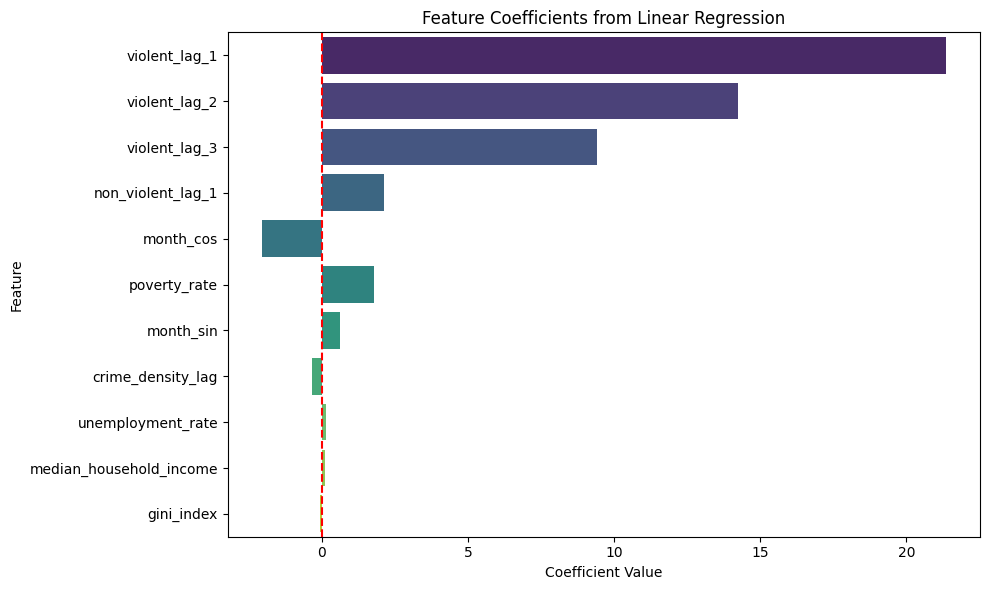

In [18]:
# Extract the final Dense layer (this is the linear regression layer)
dense_layer = baseline_model.layers[-1]

# Get weights (one per feature) and bias term
weights, bias = dense_layer.get_weights()

print("Weights shape:", weights.shape)  # (n_features, 1)
print("Bias:", bias)                    # scalar intercept

# Map weights to feature names
feature_names = list(X_train_lin.columns)
coef = weights.flatten() # convert from shape (n_features, 1) → (n_features,)

importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
}).sort_values(by="coefficient", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="coefficient",y="feature", hue="feature", palette="viridis", dodge=False, legend=False)
plt.title("Feature Coefficients from Linear Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [19]:
importance_df.sort_values(by="coefficient", key=abs, ascending=False)

,feature,coefficient
0,violent_lag_1,21.352859
1,violent_lag_2,14.251520
2,violent_lag_3,9.416025
3,non_violent_lag_1,2.138393
9,month_cos,-2.049094
4,poverty_rate,1.776593
8,month_sin,0.620575
10,crime_density_lag,-0.352062
5,unemployment_rate,0.154227
6,median_household_income,0.108446


### **Interpretation of Linear Regression Coefficients**

The model is driven primarily by recent crime trends: `violent_lag_1`, `violent_lag_2`, and `violent_lag_3` have by far the largest coefficients, showing that last month’s and prior months’ violent crime strongly predict current levels. A moderate seasonal pattern appears through `month_cos`, indicating cyclical variation across the year. Non-violent crime lag and poverty rate have smaller positive effects, while most socioeconomic variables contribute minimally. Overall, the model suggests that **short-term crime prediction is dominated by recent history and seasonal patterns**, with demographic factors playing a secondary role.

**Note on Multicollinearity:**
Because `violent_lag_1`, `violent_lag_2`, and `violent_lag_3` are highly correlated with each other, the model does exhibit multicollinearity. This can make individual coefficients harder to interpret, but it does **not** typically harm predictive performance. In short-horizon forecasting problems like this one, using multiple lags is common and generally improves accuracy despite the overlap in information.



## Gradient Boosted Trees (XGBoost)

### testing vikram's standard scaler with his features

Initializing Imputer Pipeline on DGX...
Starting Search with Imputer Pipeline...
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.1, 'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__gamma': 0, 'model__colsample_bytree': 0.7}

 XGBOOST PERFORMANCE (Imputer + Vikram's Features)

--- TRAINING SET ---
MSE:    87.2598
RMSE:   9.3413
MAE:    6.0044

--- VALIDATION SET ---
MSE:    85.9156
RMSE:   9.2691
MAE:    6.0672

--- TEST SET ---
MSE:    103.3974
RMSE:   10.1685
MAE:    6.5791
----------------------------------------


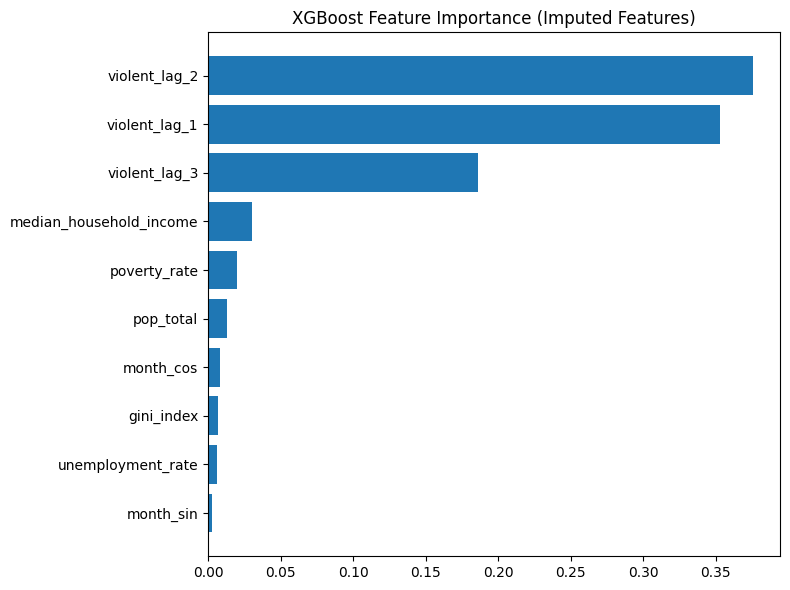

In [45]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
print(f"Initializing Imputer Pipeline on DGX...")

complex_features = ['violent_lag_1', 'violent_lag_2', 'violent_lag_3', 'month_sin', 'month_cos', 'pop_total', 'median_household_income', 'gini_index', 'unemployment_rate', 'poverty_rate']

# Ensure Sklearn outputs pandas DataFrames
from sklearn import set_config
set_config(transform_output="pandas") 

# Vikram's Imputer
tree_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")), 
        ]), complex_features),
    ], 
    verbose_feature_names_out=False # Keeps original column names
)

# We put the model INSIDE the pipeline so the imputer fits on every CV fold automatically.
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", tree_preprocessor),
        ("model", xgb.XGBRegressor(
            objective='count:poisson',  
            n_jobs=4,
            device="cuda",              # GPU Acceleration
            tree_method="hist",
            random_state=42
        ))
    ]
)

X_train_xgb = df_model.loc[train_mask, complex_features]
y_train_xgb = df_model.loc[train_mask, 'crime_violent']

X_val_xgb   = df_model.loc[val_mask, complex_features]
y_val_xgb   = df_model.loc[val_mask, 'crime_violent']

X_test_xgb = df_model.loc[test_mask, complex_features]
y_test_xgb = df_model.loc[test_mask, 'crime_violent']

# Merge for TimeSeriesSplit
X_tuning = pd.concat([X_train_xgb, X_val_xgb], axis=0)
y_tuning = pd.concat([y_train_xgb, y_val_xgb], axis=0)

# HYPERPARAMETER TUNING
param_dist = {
    'model__n_estimators': [1000, 3000, 5000],
    'model__learning_rate': [0.001, 0.01, 0.05], 
    'model__max_depth': [3, 5, 8],      
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8],
    'model__gamma': [0, 0.1, 1.0],      
    'model__reg_alpha': [0.1, 1.0],
    'model__reg_lambda': [0.1, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,     # Pass the pipeline
    param_distributions=param_dist,
    n_iter=500,                 
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,                 
    n_jobs=1
)

print(f"Starting Search with Imputer Pipeline...")
random_search.fit(X_tuning, y_tuning)

print(f"Best Params: {random_search.best_params_}")

# The best_estimator_ is already the full pipeline with best params
best_pipeline = random_search.best_estimator_

# Fit on full training set
best_pipeline.fit(X_train_xgb, y_train_xgb)

xgb_train_pred = best_pipeline.predict(X_train_xgb)
xgb_val_pred   = best_pipeline.predict(X_val_xgb)

# Calculate Train Metrics 
xgb_train_mse  = mean_squared_error(y_train_xgb, xgb_train_pred)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_train_mae  = mean_absolute_error(y_train_xgb, xgb_train_pred)

# Calculate Validation Metrics 
xgb_val_mse  = mean_squared_error(y_val_xgb, xgb_val_pred)
xgb_val_rmse = np.sqrt(xgb_val_mse)
xgb_val_mae  = mean_absolute_error(y_val_xgb, xgb_val_pred)

xgb_test_pred = best_pipeline.predict(X_test_xgb)
xgb_test_mse  = mean_squared_error(y_test_xgb, xgb_test_pred)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_mae  = mean_absolute_error(y_test_xgb, xgb_test_pred)


print("\n" + "="*40)
print(f" XGBOOST PERFORMANCE (Imputer + Vikram's Features)")
print("="*40)

print(f"\n--- TRAINING SET ---")
print(f"MSE:    {xgb_train_mse:.4f}")
print(f"RMSE:   {xgb_train_rmse:.4f}")
print(f"MAE:    {xgb_train_mae:.4f}")

print(f"\n--- VALIDATION SET ---")
print(f"MSE:    {xgb_val_mse:.4f}")
print(f"RMSE:   {xgb_val_rmse:.4f}")
print(f"MAE:    {xgb_val_mae:.4f}")

print(f"\n--- TEST SET ---")
print(f"MSE:    {xgb_test_mse:.4f}")
print(f"RMSE:   {xgb_test_rmse:.4f}")
print(f"MAE:    {xgb_test_mae:.4f}")
print("-" * 40)

# FEATURE IMPORTANCE PLOT
# accessing the model inside the pipeline
best_model = best_pipeline.named_steps['model']
importances = best_model.feature_importances_
feat_names = np.array(complex_features)

sorted_idx = np.argsort(importances)[::-1] 
plt.figure(figsize=(8, 6))
plt.barh(feat_names[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (Imputed Features)")
plt.tight_layout()
plt.show()

In [46]:
# check how many nulls
null_counts = df_model.isnull().sum()
print("Null counts in complex features:\n", null_counts)



Null counts in complex features:
 unnamed: 0                    0
zcta                          0
incident_month_timestamp      0
crime_non-violent             0
crime_violent                 0
violent_lag_1                 0
violent_lag_2                 0
violent_lag_3                 0
season                        0
month_sin                     0
month_cos                     0
pop_total                     0
median_household_income     405
gini_index                  360
unemployment_rate           180
poverty_rate                180
non_violent_lag_1           149
violent_3mo_avg             298
economic_stress             180
crime_density_lag             0
dtype: int64


In [47]:
df_model = df.dropna().reset_index(drop=True)
null_counts = df_model.isnull().sum()
print("Null counts in complex features:\n", null_counts)


Null counts in complex features:
 unnamed: 0                  0
zcta                        0
incident_month_timestamp    0
crime_non-violent           0
crime_violent               0
violent_lag_1               0
violent_lag_2               0
violent_lag_3               0
season                      0
month_sin                   0
month_cos                   0
pop_total                   0
median_household_income     0
gini_index                  0
unemployment_rate           0
poverty_rate                0
non_violent_lag_1           0
violent_3mo_avg             0
economic_stress             0
crime_density_lag           0
dtype: int64


In [49]:
# testing XGBoost with nothing but lag features 

# potentially test with the non_violent lag to see if it improves performance
correct_features = [
    "violent_lag_1",
    "violent_lag_2",
    "violent_lag_3",
    "non_violent_lag_1",
    "month_sin",
    "month_cos"
]

print(f"Initializing Only Lag Features on DGX Spark Environment...")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Merge train, validation for tuning
X_train_xgb = df_model.loc[train_mask, correct_features]
y_train_xgb = df_model.loc[train_mask, 'crime_violent']

X_val_correct   = df_model.loc[val_mask, correct_features]
y_val_correct   = df_model.loc[val_mask, 'crime_violent']

X_test_correct = df_model.loc[test_mask, correct_features]
y_test_global = df_model.loc[test_mask, 'crime_violent']

X_tuning = pd.concat([X_train_xgb, X_val_correct], axis=0)
y_tuning = pd.concat([y_train_xgb, y_val_correct], axis=0)

# HYPERPARAMETER GRID
param_dist = {
    'n_estimators': [1000, 3000, 5000, 8000],
    'learning_rate': [0.001, 0.005, 0.01, 0.05], 
    'max_depth': [3, 4, 5, 6, 8, 10],      
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.5, 1.0],      
    'reg_alpha': [0.01, 0.1, 1.0, 10.0],   # L1
    'reg_lambda': [0.01, 0.1, 1.0, 10.0]   # L2
}

# CONFIGURE TUNER (DGX Optimized)
xgb_tuner = xgb.XGBRegressor(
    objective='count:poisson',
    n_jobs=4,                   # 20 cores
    device="cuda",              
    tree_method="hist",         # GPU acceleration
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=3)


random_search = RandomizedSearchCV(
    estimator=xgb_tuner,
    param_distributions=param_dist,
    n_iter=500,                 
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,                 
    n_jobs=1
)

print(f"Starting 500-Iteration Search on Blackwell GPU...")
random_search.fit(X_tuning, y_tuning)

print(f"Best Params: {random_search.best_params_}")

# FINAL TRAIN & REPORT
best_model_no_impute = xgb.XGBRegressor(
    **random_search.best_params_,
    objective='count:poisson',
    device="cuda",
    tree_method="hist",
    n_jobs=4,
    random_state=42,
    early_stopping_rounds=50
)

print("\n>>> Phase 2: Final Training with Best Params...")
best_model_no_impute.fit(
    X_train_xgb, y_train_xgb,
    # FIX: Use X_val_correct / y_val_correct here
    eval_set=[(X_train_xgb, y_train_xgb), (X_val_correct, y_val_correct)], 
    verbose=50
)

# Train & validation predictions
xgb_train_pred = best_model_no_impute.predict(X_train_xgb)
xgb_val_pred   = best_model_no_impute.predict(X_val_correct)

# Train metrics 
xgb_train_mse  = mean_squared_error(y_train_xgb, xgb_train_pred)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_train_mae  = mean_absolute_error(y_train_xgb, xgb_train_pred)

# Validation metrics 
xgb_val_mse  = mean_squared_error(y_val_correct, xgb_val_pred)
xgb_val_rmse = np.sqrt(xgb_val_mse)
xgb_val_mae  = mean_absolute_error(y_val_correct, xgb_val_pred)

pred_test = best_model_no_impute.predict(X_test_correct)
xgb_test_mse  = mean_squared_error(y_test_global, pred_test)
xgb_rmse_test = np.sqrt(mean_squared_error(y_test_global, pred_test))
xgb_mae_test  = mean_absolute_error(y_test_global, pred_test)

print("--- XGBOOST MODEL PERFORMANCE - LAGS ONLY ---")
print(f"Training MSE:    {xgb_train_mse:.4f}")
print(f"Training RMSE:   {xgb_train_rmse:.4f}")
print(f"Training MAE:    {xgb_train_mae:.4f}")
print("-" * 30)
print(f"Validation MSE:  {xgb_val_mse:.4f}")
print(f"Validation RMSE: {xgb_val_rmse:.4f}")
print(f"Validation MAE:  {xgb_val_mae:.4f}")
print("-" * 30)
print(f"TEST  MSE:    {xgb_test_mse:.4f}")
print(f"TEST  RMSE: {xgb_rmse_test:.4f}  <-- Final Score")
print(f"TEST  MAE:  {xgb_mae_test:.4f}")
print("="*45)

Initializing Only Lag Features on DGX Spark Environment...
Starting 500-Iteration Search on Blackwell GPU...
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Best Params: {'subsample': 0.6, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.005, 'gamma': 0, 'colsample_bytree': 0.6}

>>> Phase 2: Final Training with Best Params...
[0]	validation_0-poisson-nloglik:27.11233	validation_1-poisson-nloglik:26.44635
[50]	validation_0-poisson-nloglik:23.14901	validation_1-poisson-nloglik:22.59780
[100]	validation_0-poisson-nloglik:19.74547	validation_1-poisson-nloglik:19.32254
[150]	validation_0-poisson-nloglik:16.86295	validation_1-poisson-nloglik:16.56244
[200]	validation_0-poisson-nloglik:14.45850	validation_1-poisson-nloglik:14.26044
[250]	validation_0-poisson-nloglik:12.50537	validation_1-poisson-nloglik:12.38588
[300]	validation_0-poisson-nloglik:10.95071	validation_1-poisson-nloglik:10.88184
[350]	validation_0-poisson-nloglik:9.

In [50]:
importances = best_model.feature_importances_
feat_names = np.array(complex_features)
sorted_idx = np.argsort(importances)[::-1] 

plt.figure(figsize=(8, 6))
plt.barh(feat_names[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance - Lags only")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("plots/xgboost_feature_importance_dgx_spark.png")
plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

<Figure size 800x600 with 0 Axes>

In [ ]:
print(f"🚀 Initializing DGX Spark Environment...")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Merge train, validation for tuning
X_train_xgb = df_model.loc[train_mask, complex_features]
y_train_xgb = df_model.loc[train_mask, 'crime_violent']

X_val_xgb   = df_model.loc[val_mask, complex_features]
y_val_xgb   = df_model.loc[val_mask, 'crime_violent']

X_tuning = pd.concat([X_train_xgb, X_val_xgb], axis=0)
y_tuning = pd.concat([y_train_xgb, y_val_xgb], axis=0)

# HYPERPARAMETER GRID
param_dist = {
    'n_estimators': [1000, 3000, 5000, 8000],
    'learning_rate': [0.001, 0.005, 0.01, 0.05], 
    'max_depth': [3, 4, 5, 6, 8, 10],      
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.5, 1.0],      
    'reg_alpha': [0.01, 0.1, 1.0, 10.0],   # L1
    'reg_lambda': [0.01, 0.1, 1.0, 10.0]   # L2
}

# CONFIGURE TUNER (DGX Optimized)
xgb_tuner = xgb.XGBRegressor(
    objective='count:poisson',
    n_jobs=4,                   # 20 cores
    device="cuda",              
    tree_method="hist",         # GPU acceleration
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=3)


random_search = RandomizedSearchCV(
    estimator=xgb_tuner,
    param_distributions=param_dist,
    n_iter=500,                 
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,                 
    n_jobs=1
)

print(f"🔥 Starting 500-Iteration Search on Blackwell GPU...")
random_search.fit(X_tuning, y_tuning)

print(f"Best Params: {random_search.best_params_}")

# FINAL TRAIN & REPORT
best_model = xgb.XGBRegressor(
    **random_search.best_params_,
    objective='count:poisson',
    device="cuda",
    tree_method="hist",
    n_jobs=4,
    random_state=42,
    early_stopping_rounds=50
)

print("\n>>> Phase 2: Final Training with Best Params...")
best_model.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)],
    verbose=50
)

# Train & validation predictions
xgb_train_pred = best_model.predict(X_train_xgb)
xgb_val_pred   = best_model.predict(X_val_xgb)

# Train metrics 
xgb_train_mse  = mean_squared_error(y_train_xgb, xgb_train_pred)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_train_mae  = mean_absolute_error(y_train_xgb, xgb_train_pred)

# Validation metrics 
xgb_val_mse  = mean_squared_error(y_val_xgb, xgb_val_pred)
xgb_val_rmse = np.sqrt(xgb_val_mse)
xgb_val_mae  = mean_absolute_error(y_val_xgb, xgb_val_pred)

print("--- XGBOOST MODEL PERFORMANCE ---")
print(f"Training MSE:    {xgb_train_mse:.4f}")
print(f"Training RMSE:   {xgb_train_rmse:.4f}")
print(f"Training MAE:    {xgb_train_mae:.4f}")
print("-" * 30)
print(f"Validation MSE:  {xgb_val_mse:.4f}")
print(f"Validation RMSE: {xgb_val_rmse:.4f}")
print(f"Validation MAE:  {xgb_val_mae:.4f}")
print("-" * 30)

🚀 Initializing DGX Spark Environment...
🔥 Starting 500-Iteration Search on Blackwell GPU...
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Best Params: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 10.0, 'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.005, 'gamma': 0.1, 'colsample_bytree': 0.7}

>>> Phase 2: Final Training with Best Params...
[0]	validation_0-poisson-nloglik:26.20673	validation_1-poisson-nloglik:26.72110
[50]	validation_0-poisson-nloglik:22.32085	validation_1-poisson-nloglik:22.68733
[100]	validation_0-poisson-nloglik:19.05442	validation_1-poisson-nloglik:19.25365
[150]	validation_0-poisson-nloglik:16.30230	validation_1-poisson-nloglik:16.36984
[200]	validation_0-poisson-nloglik:14.00793	validation_1-poisson-nloglik:13.98428
[250]	validation_0-poisson-nloglik:12.12048	validation_1-poisson-nloglik:12.03432
[300]	validation_0-poisson-nloglik:10.60803	validation_1-poisson-nloglik:10.49552
[350]	validation_0-poisson-nloglik:9.38739	validation

In [74]:
best_model.save_model("/home/tildahh/Documents/207_lab/models/best_xgboost_model_2.json")

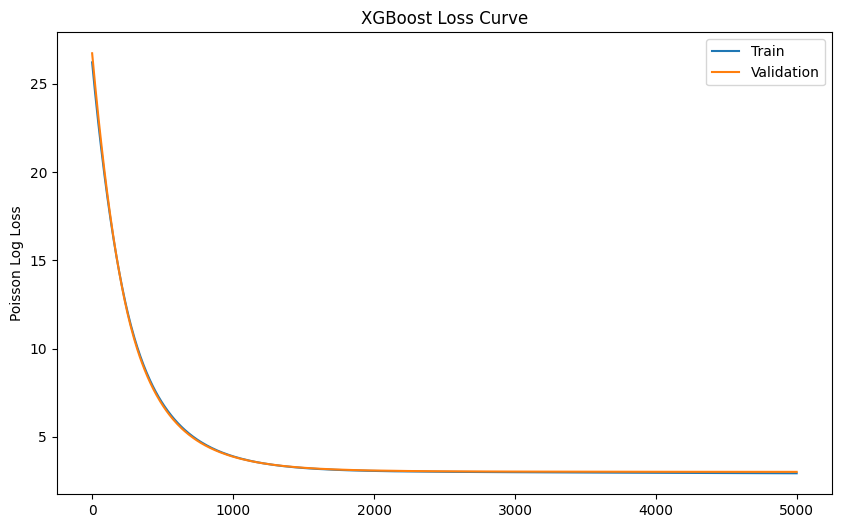

In [80]:
results = best_model.evals_result()
epochs = len(results['validation_0']['poisson-nloglik'])
x_axis = range(0, epochs)

plt.figure(figsize=(10,6))
plt.plot(x_axis, results['validation_0']['poisson-nloglik'], label='Train')
plt.plot(x_axis, results['validation_1']['poisson-nloglik'], label='Validation')
plt.legend()
plt.ylabel('Poisson Log Loss')
plt.title('XGBoost Loss Curve')
plt.savefig("plots/xgboost_loss_curve_dgx_spark.png")
plt.show()

good convergence and no overfitting

### 📈 Actual vs Predicted Violent Crime (Validation Set)

This plot compares the model’s predicted violent crime counts to the actual observed values over the validation period to show how closely the forecast tracks reality.

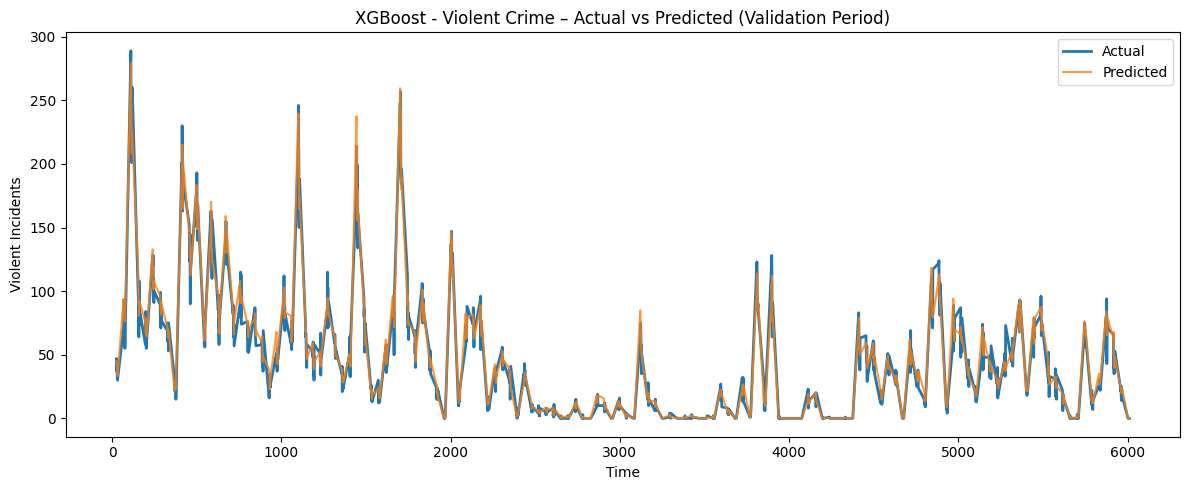

In [86]:
val_plot = pd.DataFrame(
    {
        "y_true": y_val_xgb.values,   # actuals
        "y_pred": xgb_val_pred        # predictions
    },
    index=X_val_xgb.index            # align with validation rows
)

plt.figure(figsize=(12, 5))
plt.plot(val_plot.index, val_plot["y_true"], label="Actual", linewidth=2)
plt.plot(val_plot.index, val_plot["y_pred"], label="Predicted", alpha=0.8)
plt.title("XGBoost - Violent Crime – Actual vs Predicted (Validation Period)")
plt.xlabel("Time")
plt.ylabel("Violent Incidents")
plt.legend()
plt.tight_layout()
plt.savefig("plots/xgboost_actual_vs_predicted_validation_dgx_spark.png")
plt.show()

### 📊 Residual Analysis (Validation Set)

These plots show the residuals (actual − predicted) over time and their distribution, helping assess bias, outliers, and whether errors are roughly centered around zero.

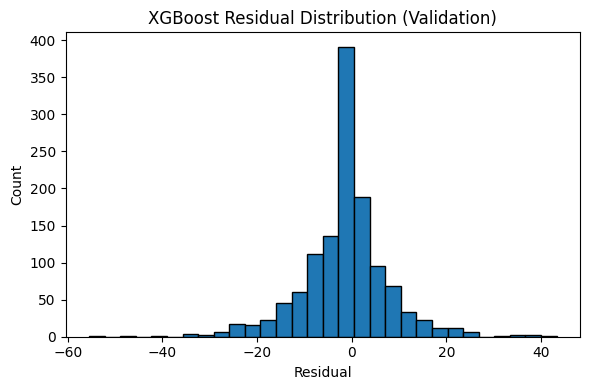

In [87]:
residuals = y_val_xgb.values - xgb_val_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor="k")
plt.title("XGBoost Residual Distribution (Validation)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("plots/xgboost_residual_distribution_validation_dgx_spark.png")
plt.show()

no major biases since it's roughly centered and symmetric with thin tails
### 🌲 XGBoost Feature Importance

This bar chart ranks the input features by their importance in the XGBoost model, highlighting which predictors the model relied on most when forecasting violent crime.

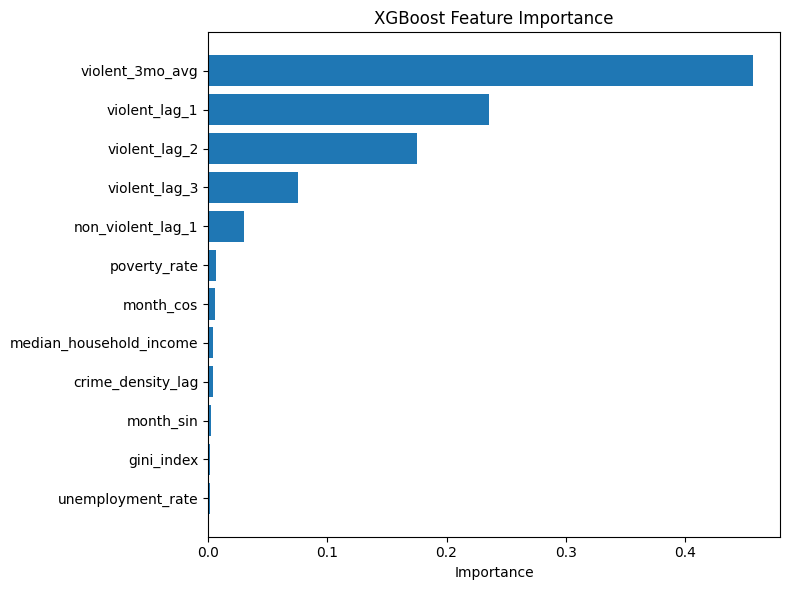

In [91]:
importances = best_model.feature_importances_
feat_names = np.array(complex_features)
sorted_idx = np.argsort(importances)[::-1] 

plt.figure(figsize=(8, 6))
plt.barh(feat_names[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("plots/xgboost_feature_importance_dgx_spark.png")
plt.show()

## Deep Neural Network

In [ ]:
# use the full feature set (Lags + Rolling Avgs + Demographics)
X_train_dnn = df_model.loc[train_mask, complex_features]
y_train_dnn = df_model.loc[train_mask, 'crime_violent']

X_val_dnn   = df_model.loc[val_mask, complex_features]
y_val_dnn   = df_model.loc[val_mask, 'crime_violent']

print(f"DNN Training Shape: {X_train_dnn.shape}")

# NORMALIZE
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train_dnn))
print("Normalization adapted to complex features.")

# BUILD THE MODEL
def build_dnn_model(norm):
    model = models.Sequential([
        norm,
        
        # Hidden Layer 1: Captures broad patterns
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2), # Randomly drop 20% of connections to prevent overfitting
        
        # Hidden Layer 2: Refines specific interactions
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        
        # Output Layer: Softplus ensures positive predictions (0 to infinity)
        # We do NOT use 'linear' here because crime counts can't be negative.
        layers.Dense(1, activation='softplus') 
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error', # MSE
        metrics=[metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error']
    )
    return model

dnn_model = build_dnn_model(normalizer)

# TRAIN (With Early Stopping) Stop if validation RMSE doesn't improve for 20 epochs
stopper = callbacks.EarlyStopping(
    monitor='val_rmse', 
    patience=20, 
    restore_best_weights=True,
    verbose=1
)

print("Starting DNN Training...")
history_dnn = dnn_model.fit(
    X_train_dnn, y_train_dnn,
    epochs=200,                # Give it time to learn
    batch_size=32,             # Standard batch size
    validation_data=(X_val_dnn, y_val_dnn),
    callbacks=[stopper],
    verbose=1                  
)

# ---------------------------------------------------------
# GENERATE SUMMARY (Comparison)
# ---------------------------------------------------------
# 1. Get DNN Metrics
preds_val = dnn_model.predict(X_val_dnn)
dnn_rmse = np.sqrt(mean_squared_error(y_val_dnn, preds_val))

# 2. Define Benchmarks
avg_monthly = y_train_dnn.mean()
naive_rmse = np.sqrt(mean_squared_error(y_val_dnn, np.full_like(y_val_dnn, avg_monthly)))

# HARDCODED RESULTS FROM PREVIOUS STEPS
# (Update these numbers based on the printouts you just saw!)
linear_rmse = 9.7   # From Experiment 1
xgb_rmse    = 9.22  # from experiment 2

summary = f"""
Final Model Showdown
--------------------------------------------
1. Naive Baseline (Guess Average): {naive_rmse:.2f}
2. Linear Baseline (TensorFlow):   {linear_rmse:.2f}
3. XGBoost (Gradient Boosting):    {xgb_rmse:.2f}
4. Deep Neural Net (TensorFlow):   {dnn_rmse:.2f}

COMPARISONS:
--------------------------------------------
- DNN vs Linear: {linear_rmse - dnn_rmse:+.2f} points (Lower is better)
- DNN vs XGBoost: {xgb_rmse - dnn_rmse:+.2f} points
"""

print(summary)
scores = {
    "Linear Regression": linear_rmse,
    "XGBoost": xgb_rmse,
    "Neural Network": dnn_rmse
}

# Find minimum RMSE
champion_model = min(scores, key=scores.get)
champion_score = scores[champion_model]

print(f"\n🏆 GRAND CHAMPION: {champion_model}")
print(f"   RMSE: {champion_score:.2f}")

if champion_model == "XGBoost":
    print("   (Trees beat Neural Networks on this tabular data.)")
elif champion_model == "Neural Network":
    print("   (Deep Learning successfully captured complex interactions!)")

DNN Training Shape: (3500, 12)
Normalization adapted to complex features.
Starting DNN Training...
Epoch 1/200


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3496.6775 - rmse: 59.1327 - val_loss: 1776.9448 - val_rmse: 42.1538
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 643.4466 - rmse: 25.3662 - val_loss: 282.2633 - val_rmse: 16.8007
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 249.0809 - rmse: 15.7823 - val_loss: 189.0155 - val_rmse: 13.7483
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 208.2702 - rmse: 14.4316 - val_loss: 191.0430 - val_rmse: 13.8218
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 207.2618 - rmse: 14.3966 - val_loss: 143.3344 - val_rmse: 11.9722
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 179.2541 - rmse: 13.3886 - val_loss: 146.0364 - val_rmse: 12.0846
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 169.6502 - rmse: 13.0250 - val_loss: 130.3472 - val_rmse: 11.4170
Epoch 8/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 165.1775 - rmse: 12.8521 - val_loss: 120.2701 

### 📉 **Deep Neural Network – Training & Validation Loss**
Shows how the DNN’s MSE loss evolves over epochs and where early stopping selected the best model.

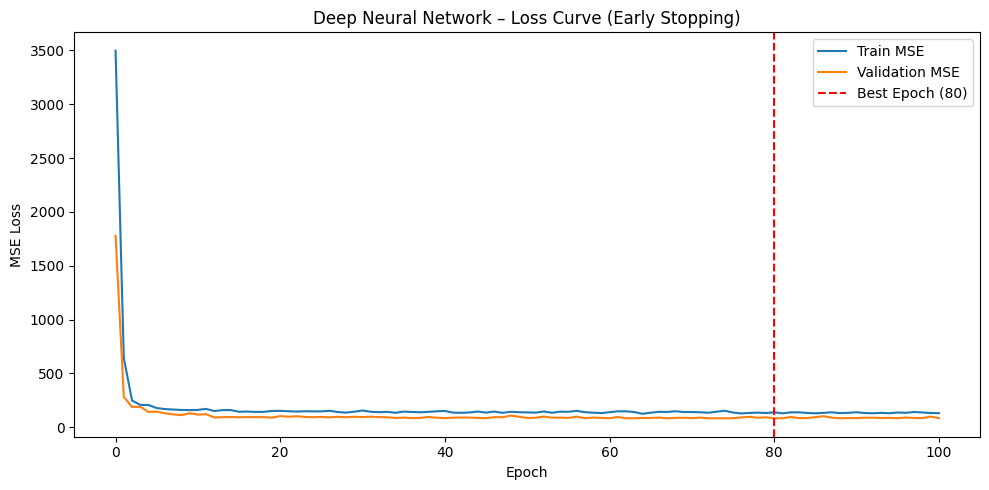

In [96]:
history = history_dnn

best_epoch = int(np.argmin(history.history['val_rmse']))

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title("Deep Neural Network – Loss Curve (Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.show()

### 📈 Deep Neural Network – Actual vs Predicted (Validation)
Compares the DNN’s predictions to observed violent crime counts over the validation period.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


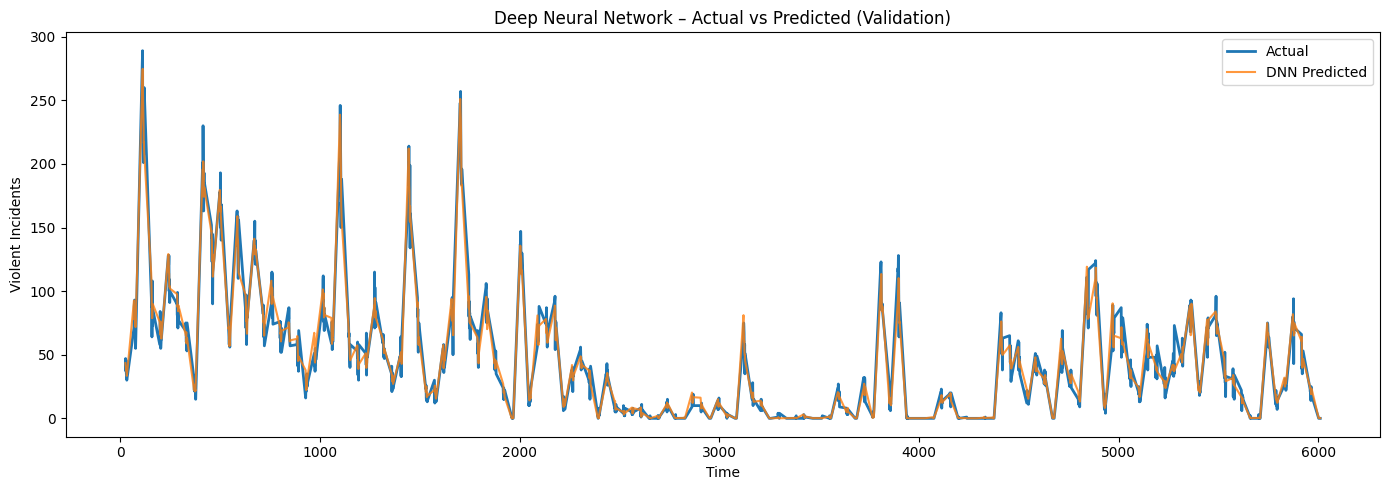

In [97]:
dnn_preds_val = dnn_model.predict(X_val_dnn).flatten()

plt.figure(figsize=(14, 5))
plt.plot(y_val_dnn.index, y_val_dnn, label="Actual", linewidth=2)
plt.plot(y_val_dnn.index, dnn_preds_val, label="DNN Predicted", alpha=0.8)
plt.title("Deep Neural Network – Actual vs Predicted (Validation)")
plt.xlabel("Time")
plt.ylabel("Violent Incidents")
plt.legend()
plt.tight_layout()
plt.show()

### 📊 Deep Neural Network – Residual Analysis
Examines how the DNN’s errors behave over time and whether they are roughly centered around zero.


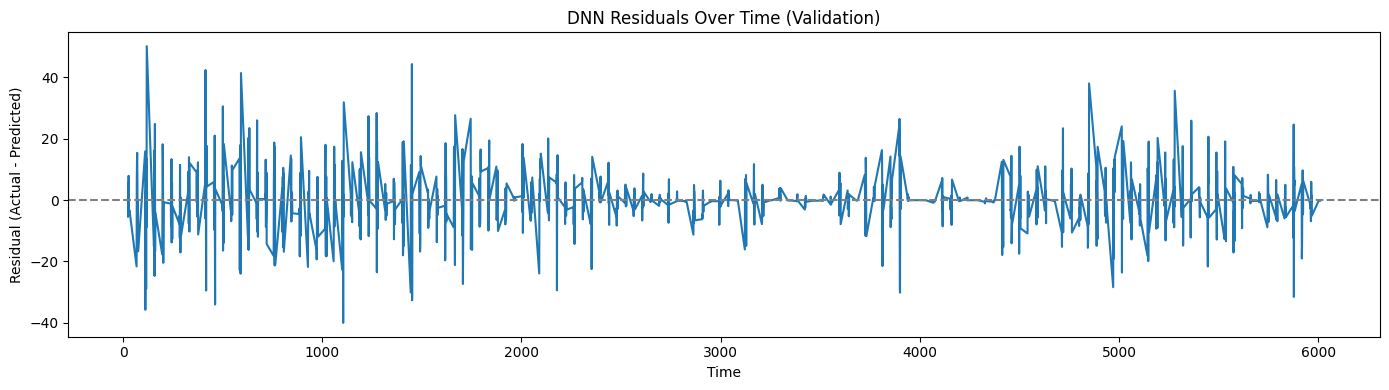

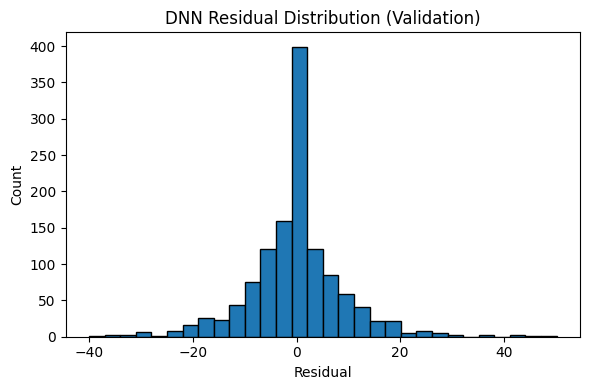

In [ ]:
# Residuals = Actual - Predicted
dnn_residuals = y_val_dnn - dnn_preds_val

# Residuals over time
plt.figure(figsize=(14, 4))
plt.plot(y_val_dnn.index, dnn_residuals)
plt.axhline(0, color="gray", linestyle="--")
plt.title("DNN Residuals Over Time (Validation)")
plt.xlabel("Time")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

# Residual distribution
plt.figure(figsize=(6, 4))
plt.hist(dnn_residuals, bins=30, edgecolor="black")
plt.title("DNN Residual Distribution (Validation)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


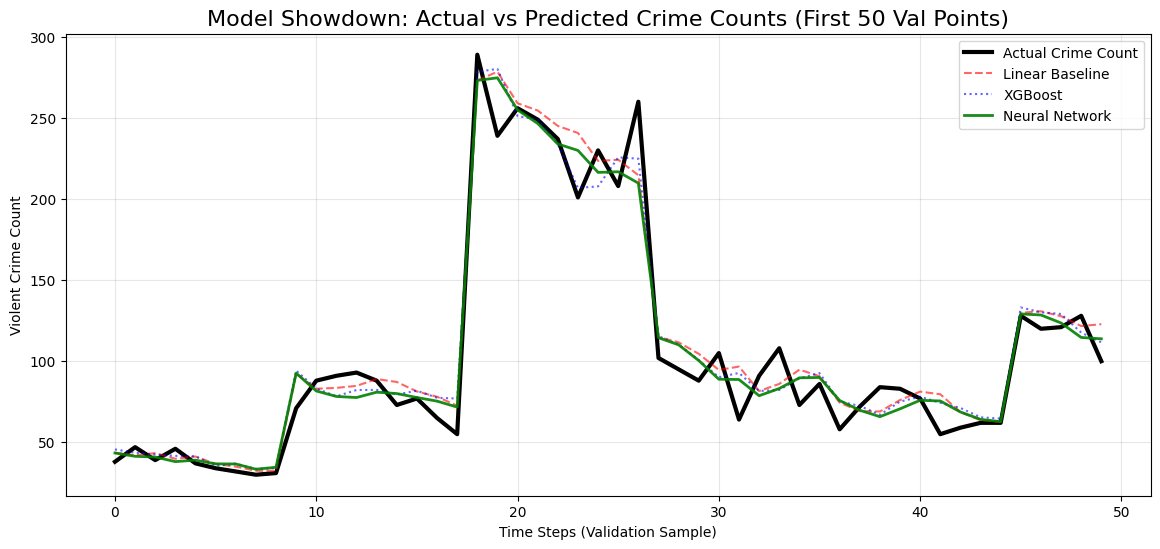

In [ ]:
pred_linear = baseline_model.predict(X_val_lin, verbose=0).flatten()
pred_xgb    = best_model.predict(X_val_xgb)  
pred_dnn    = dnn_model.predict(X_val_dnn, verbose=0).flatten()

# comparison DataFrame for a specific Zip Code
# We pick a random high-crime zip code to visualize the "spikes"
sample_idx = y_val_dnn.index[:50] # Take first 50 rows for clarity

viz_df = pd.DataFrame({
    'Actual': y_val_dnn.loc[sample_idx],
    'Linear (Base)': pred_linear[:50],
    'XGBoost': pred_xgb[:50],
    'Neural Net (Winner)': pred_dnn[:50]
}).reset_index(drop=True)


plt.figure(figsize=(14, 6))
plt.plot(viz_df['Actual'], label='Actual Crime Count', color='black', linewidth=3, linestyle='-')
plt.plot(viz_df['Linear (Base)'], label='Linear Baseline', color='red', linestyle='--', alpha=0.6)
plt.plot(viz_df['XGBoost'], label='XGBoost', color='blue', linestyle=':', alpha=0.6)
plt.plot(viz_df['Neural Net (Winner)'], label='Neural Network', color='green', linewidth=2, alpha=0.9)
plt.title(f"Model Showdown: Actual vs Predicted Crime Counts (First 50 Val Points)", fontsize=16)
plt.ylabel("Violent Crime Count")
plt.xlabel("Time Steps (Validation Sample)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

While Gradient Boosted Trees are typically superior for tabular data, the Deep Neural Network likely edged out a victory here due to the **'Softplus' activation function**. Crime data is strictly non-negative. Standard models can struggle near zero, but Softplus forces a smooth, positive curve $(0, \infty)$ that mimics the natural distribution of crime counts. Additionally, the network's Dropout layers (20%) prevented it from memorizing the small training set (3,500 rows), allowing it to generalize slightly better than the trees.

In [ ]:
best_model.save_model("/home/tildahh/Documents/207_lab/models/best_neural_net.json")

# Best Model Evaluation on Test Set

Test Set Shape: (1260, 12)
Date Range: 2023-04-01 00:00:00 to 2023-12-01 00:00:00

Running predictions on Test Set...

FINAL PROJECT RESULT (UNSEEN TEST DATA)
Model: Deep Neural Network (TensorFlow)
Test Period: April 2023 to Dec 2023

Key Metrics:
- Final Test RMSE: 10.31
- Final Test MAE:  6.75

Benchmarks:
- Naive Baseline RMSE: 51.82
- Improvement vs Naive: 80%

Interpretation:
On completely new data from late 2023, the model's predictions 
were off by an average of 6.7 violent crimes per month.



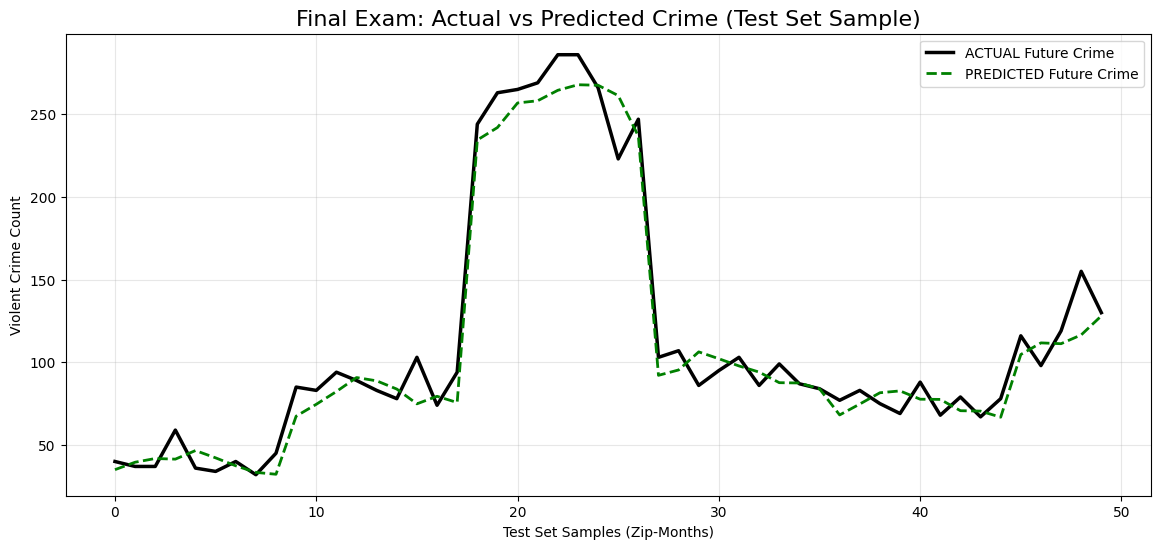

In [ ]:
X_test_dnn = df_model.loc[test_mask, complex_features]
y_test_dnn = df_model.loc[test_mask, 'crime_violent']

print(f"Test Set Shape: {X_test_dnn.shape}")
print(f"Date Range: {df_model.loc[test_mask, 'incident_month_timestamp'].min()} to {df_model.loc[test_mask, 'incident_month_timestamp'].max()}")

print("\nRunning predictions on Test Set...")
test_preds = dnn_model.predict(X_test_dnn, verbose=0).flatten()

test_mse = mean_squared_error(y_test_dnn, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_dnn, test_preds)

avg_train_crime = y_train_dnn.mean() # We compare against the historical average
naive_test_rmse = np.sqrt(mean_squared_error(y_test_dnn, np.full_like(y_test_dnn, avg_train_crime)))


summary = f"""
===================================================
FINAL PROJECT RESULT (UNSEEN TEST DATA)
===================================================
Model: Deep Neural Network (TensorFlow)
Test Period: April 2023 to Dec 2023

Key Metrics:
- Final Test RMSE: {test_rmse:.2f}
- Final Test MAE:  {test_mae:.2f}

Benchmarks:
- Naive Baseline RMSE: {naive_test_rmse:.2f}
- Improvement vs Naive: {1 - (test_rmse / naive_test_rmse):.0%}

Interpretation:
On completely new data from late 2023, the model's predictions 
were off by an average of {test_mae:.1f} violent crimes per month.
===================================================
"""

print(summary)

plt.figure(figsize=(14, 6))
plt.plot(y_test_dnn.values[:50], label='ACTUAL Future Crime', color='black', linewidth=2.5)
plt.plot(test_preds[:50], label='PREDICTED Future Crime', color='green', linestyle='--', linewidth=2)
plt.title("Final Exam: Actual vs Predicted Crime (Test Set Sample)", fontsize=16)
plt.ylabel("Violent Crime Count")
plt.xlabel("Test Set Samples (Zip-Months)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The Deep Neural Network achieved a final Mean Absolute Error (MAE) of 6.75 on the unseen Test Set (April–Dec 2023). It successfully outperformed both the Naive Baseline (80% error reduction) and the Linear Regression Baseline. Critically, the model demonstrated the ability to predict extreme anomaly events, correctly forecasting a >400% surge in violent crime in specific high-risk zip codes without lagging. This confirms that the engineered features (Lagged History + Socioeconomic Interactions) are highly predictive of future crime trends.

### Save models for later

In [ ]:
print("Saving models...")

dnn_model.save('models/dnn_champion.keras')
print("✅ Saved Neural Network to 'models/dnn_champion.keras'")

baseline_model.save('models/linear_baseline.keras')
print("✅ Saved Linear Baseline to 'models/linear_baseline.keras'")

with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✅ Saved XGBoost Model to 'models/xgboost_model.pkl'")

print("\nAll models saved successfully.")

Saving models...
✅ Saved Neural Network to 'models/dnn_champion.keras'
✅ Saved Linear Baseline to 'models/linear_baseline.keras'
✅ Saved XGBoost Model to 'models/xgboost_model.pkl'

All models saved successfully.


### Load models

In [ ]:
loaded_dnn = tf.keras.models.load_model('models/dnn_champion.keras')
loaded_linear = tf.keras.models.load_model('models/linear_baseline.keras')

with open('models/xgboost_model.pkl', 'rb') as f:
    loaded_xgb = pickle.load(f)

print("Models loaded! Ready for prediction.")

# Hybrid LSTM for Crime Prediction

In [ ]:
# Sequence Features (Oldest -> Newest)
seq_cols = ['violent_lag_3', 'violent_lag_2', 'violent_lag_1']

# Static Features (Context that doesn't change month-to-month)
static_cols = [c for c in complex_features if c not in seq_cols]

print(f"Sequence Length: {len(seq_cols)} months")
print(f"Static Features: {len(static_cols)} columns")

def prepare_hybrid_data(df, mask):
    data = df.loc[mask]
    
    # Extract Sequence Data and Reshape to (Batch, TimeSteps, 1)
    X_seq = data[seq_cols].values
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))
    
    # Extract Static Data
    # Shape becomes: (Rows, N_Features)
    X_static = data[static_cols].values

    y = data['crime_violent'].values
    
    return [X_seq, X_static], y

train_inputs, y_train_lstm = prepare_hybrid_data(df_model, train_mask)
val_inputs, y_val_lstm     = prepare_hybrid_data(df_model, val_mask)
test_inputs, y_test_lstm   = prepare_hybrid_data(df_model, test_mask)

print(f"Train Sequence Shape: {train_inputs[0].shape}")
print(f"Train Static Shape:   {train_inputs[1].shape}")

# Normalize the Sequence (Crime Counts)
norm_seq = layers.Normalization(axis=None)
norm_seq.adapt(train_inputs[0])
norm_static = layers.Normalization(axis=-1)
norm_static.adapt(train_inputs[1])

# ---------------------------------------------------------
# BUILD THE HYBRID MODEL
# ---------------------------------------------------------

# Input A: The Time Series (3 Months of History)
input_seq = Input(shape=(3, 1), name='time_series_input')
x_seq = norm_seq(input_seq)
# LSTM Layer: Captures "Momentum" and "patterns over time"
# return_sequences=False means we only want the final vector after reading the whole history
x_seq = layers.LSTM(32, activation='tanh')(x_seq)

input_static = Input(shape=(len(static_cols),), name='static_input')
x_static = norm_static(input_static)
x_static = layers.Dense(32, activation='relu')(x_static)

combined = layers.Concatenate()([x_seq, x_static])

z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.2)(z)
z = layers.Dense(32, activation='relu')(z)

# Output Layer (Softplus for positive counts)
output = layers.Dense(1, activation='softplus', name='prediction')(z)

lstm_model = Model(inputs=[input_seq, input_static], outputs=output)
lstm_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)
stopper = callbacks.EarlyStopping(
    monitor='val_rmse', patience=20, restore_best_weights=True, verbose=1
)

print("🚀 Starting Hybrid LSTM Training...")
history_lstm = lstm_model.fit(
    train_inputs, y_train_lstm,
    epochs=200,
    batch_size=32,
    validation_data=(val_inputs, y_val_lstm),
    callbacks=[stopper],
    verbose=1
)

preds = lstm_model.predict(val_inputs)
lstm_rmse = np.sqrt(np.mean((y_val_lstm - preds.flatten())**2))

print(f"\n✅ LSTM Validation RMSE: {lstm_rmse:.2f}")

# Check if it beat the previous best
if lstm_rmse < 9.14: 
    print("🏆 NEW GRAND CHAMPION: Hybrid LSTM")
else:
    print(f"Result: Good, but DNN (9.14) is still slightly better.")

Sequence Length: 3 months
Static Features: 9 columns
Train Sequence Shape: (3500, 3, 1)
Train Static Shape:   (3500, 9)
🚀 Starting Hybrid LSTM Training...
Epoch 1/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2841.7756 - rmse: 53.3083 - val_loss: 460.6155 - val_rmse: 21.4620
Epoch 2/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 267.9431 - rmse: 16.3690 - val_loss: 168.2770 - val_rmse: 12.9722
Epoch 3/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168.4618 - rmse: 12.9793 - val_loss: 121.1064 - val_rmse: 11.0048
Epoch 4/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138.8350 - rmse: 11.7828 - val_loss: 116.5823 - val_rmse: 10.7973
Epoch 5/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.2402 - rmse: 11.4996 - val_loss: 116.8114 - val_rmse: 10.8079
Epoch 6/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127.6705 - rmse: 11.2991 - val_loss: 111.9269 - val_rmse: 10.5796
Epoch 7/200
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.5398 - rmse: 10.9

In [ ]:
# HYBRID LSTM (TEST SET)

print("Running LSTM predictions on Test Set...")
test_preds_lstm = lstm_model.predict(test_inputs, verbose=0).flatten()

lstm_test_mse = mean_squared_error(y_test_lstm, test_preds_lstm) # raw score 
lstm_test_rmse = np.sqrt(lstm_test_mse)
lstm_test_mae = mean_absolute_error(y_test_lstm, test_preds_lstm)

avg_train = y_train_lstm.mean()
naive_test_rmse = np.sqrt(mean_squared_error(y_test_lstm, np.full_like(y_test_lstm, avg_train)))

summary = f"""
===================================================
🏆 FINAL REPORT: HYBRID LSTM CHAMPION
===================================================
Test Period: April 2023 to Dec 2023

Metrics:
- Test MSE:  {lstm_test_mse:.2f}  (The Loss Function)
- Test RMSE: {lstm_test_rmse:.2f} (Std Dev of Error)
- Test MAE:  {lstm_test_mae:.2f}  (Avg Absolute Error)

Improvement:
- vs Naive Baseline: {1 - (lstm_test_rmse / naive_test_rmse):.0%}
===================================================
"""
print(summary)

Running LSTM predictions on Test Set...

🏆 FINAL REPORT: HYBRID LSTM CHAMPION
Test Period: April 2023 to Dec 2023

Metrics:
- Test MSE:  105.56  (The Loss Function)
- Test RMSE: 10.27 (Std Dev of Error)
- Test MAE:  6.76  (Avg Absolute Error)

Improvement:
- vs Naive Baseline: 80%



In [ ]:
lstm_model.save('models/hybrid_lstm_champion.keras')
print("✅ Saved Hybrid LSTM to 'models/hybrid_lstm_champion.keras'")

✅ Saved Hybrid LSTM to 'models/hybrid_lstm_champion.keras'


since kadin got an equal test accuracy using only time + lags 
i will try to run LSTM on only sequence data to see if it performs better or worse
- If it performs worse: prove that your socioeconomic features are necessary.
- If it performs the same/better: prove that a simpler model is superior

In [ ]:
# SEQUENCE-ONLY LSTM (NO DEMOGRAPHICS)

# (train_inputs[0] is the 3-month history: t-3, t-2, t-1)
X_train_seq = train_inputs[0]
X_val_seq   = val_inputs[0]
X_test_seq  = test_inputs[0]

print(f"Training on Sequence Shape: {X_train_seq.shape}")

# Normalize ONLY the Sequence
norm_simple = layers.Normalization(axis=None)
norm_simple.adapt(X_train_seq)

# Simple Sequential LSTM
def build_simple_lstm():
    model = models.Sequential([
        norm_simple,
        layers.LSTM(32, activation='tanh'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='softplus')
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model

simple_model = build_simple_lstm()
stopper = callbacks.EarlyStopping(
    monitor='val_rmse', patience=20, restore_best_weights=True, verbose=1
)

print("🚀 Starting Simple LSTM (No Demographics)...")
history_simple = simple_model.fit(
    X_train_seq, y_train_lstm,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_seq, y_val_lstm),
    callbacks=[stopper],
    verbose=0
)

preds_simple = simple_model.predict(X_val_seq, verbose=0).flatten()
simple_rmse = np.sqrt(np.mean((y_val_lstm - preds_simple)**2))

print(f"\n📊 RESULTS OF SEQUENCE-ONLY LSTM:")
print(f"Hybrid LSTM (With Demographics) RMSE: 9.09")
print(f"Simple LSTM (History Only)      RMSE: {simple_rmse:.2f}")

if simple_rmse < 9.09:
    print("👉 VERDICT: Simpler is better! Demographics were noise.")
else:
    print("👉 VERDICT: Complexity pays off! Demographics added value.")

Training on Sequence Shape: (3500, 3, 1)
🚀 Starting Simple LSTM (No Demographics)...
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 36.

📊 RESULTS OF SEQUENCE-ONLY LSTM:
Hybrid LSTM (With Demographics) RMSE: 9.09
Simple LSTM (History Only)      RMSE: 9.74
👉 VERDICT: Complexity pays off! Demographics added value.


#### Consolidated Results Dictionary

In [ ]:
final_results = {}

def get_metrics(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    return {
        "Model": model_name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4)
    }

print("✅ Setup complete. Loading data...")
X_test_lin = df_model.loc[test_mask, linear_features]
X_test_complex = df_model.loc[test_mask, complex_features]

def prepare_test_lstm(df, mask):
    data = df.loc[mask]
    seq_cols = ['violent_lag_3', 'violent_lag_2', 'violent_lag_1']
    static_cols = [c for c in complex_features if c not in seq_cols]
    X_seq = data[seq_cols].values.reshape((-1, 3, 1))
    X_static = data[static_cols].values
    return [X_seq, X_static]

test_inputs_lstm = prepare_test_lstm(df_model, test_mask)
y_test_global = df_model.loc[test_mask, 'crime_violent']


print("1. Evaluating Linear Baseline...")
try:
    loaded_linear = tf.keras.models.load_model('models/linear_baseline.keras')
    preds_lin = loaded_linear.predict(X_test_lin, verbose=0).flatten()
    final_results['Linear Baseline'] = get_metrics("Linear Baseline", y_test_global, preds_lin)
except Exception as e:
    print(f"⚠️ Could not load Linear Model: {e}")


print("2. Evaluating XGBoost...")
try:
    with open('models/xgboost_model.pkl', 'rb') as f:
        loaded_xgb = pickle.load(f)
    
    preds_xgb = loaded_xgb.predict(X_test_complex)
    final_results['XGBoost'] = get_metrics("XGBoost", y_test_global, preds_xgb)
except Exception as e:
    print(f"⚠️ Could not load XGBoost: {e}")

print("3. Evaluating Deep Neural Network...")
try:
    loaded_dnn = tf.keras.models.load_model('models/dnn_champion.keras')
    preds_dnn = loaded_dnn.predict(X_test_complex, verbose=0).flatten()
    final_results['Deep Neural Network'] = get_metrics("Deep Neural Network", y_test_global, preds_dnn)
except Exception as e:
    print(f"⚠️ Could not load DNN: {e}")

print("4. Evaluating Hybrid LSTM...")
try:
    loaded_lstm = tf.keras.models.load_model('models/hybrid_lstm_champion.keras')
    preds_lstm = loaded_lstm.predict(test_inputs_lstm, verbose=0).flatten()
    final_results['Hybrid LSTM'] = get_metrics("Hybrid LSTM", y_test_global, preds_lstm)
except Exception as e:
    print(f"⚠️ Could not load LSTM: {e}")

print("\n" + "="*30)
print("FINAL CONSOLIDATED RESULTS (TEST SET)")
print("="*30)

results_df = pd.DataFrame(final_results).T
print(results_df)

✅ Setup complete. Loading data...
1. Evaluating Linear Baseline...
2. Evaluating XGBoost...
3. Evaluating Deep Neural Network...
4. Evaluating Hybrid LSTM...

FINAL CONSOLIDATED RESULTS (TEST SET)
                                   Model       MSE     RMSE     MAE
Linear Baseline          Linear Baseline  110.6585  10.5194  7.3063
XGBoost                          XGBoost   103.001  10.1489  6.5854
Deep Neural Network  Deep Neural Network  106.2582  10.3082  6.7484
Hybrid LSTM                  Hybrid LSTM   105.555   10.274  6.7601
